In [1]:
import numpy as np
import pandas as pd
import h5py
import sys
from math import exp, log
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from statistics import mean
from scipy.optimize import curve_fit

sys.path.insert(0, './radiometric')
from LUT_functions import pixel_registration, create_LUT_df
import scipy

from pathlib import Path

In [2]:
#choose filepath to desired data
path = '/Volumes/KESU/may19/LUTS/'
#note cam definitions are flipped as of FLIRPY ffc fix 
cal_file2 =  '/Volumes/KESU/calibration_files/cam1pixel.h5'
cal_file1 =  '/Volumes/KESU/calibration_files/cam2pixel.h5'

In [4]:
waves= np.linspace(7,12,61)
TEMPS = np.linspace(25,80,12)

array([25., 30., 35., 40., 45., 50., 55., 60., 65., 70., 75., 80.])

In [5]:
#select ROI
ymin2 = 90; ymax2 = 150;
ymin1 = 115; ymax1 = 175;

FOV = 53.51 ;
HFOV = FOV/4;
angles = np.round(np.linspace(-HFOV,HFOV,ymax2-ymin2))

In [6]:
'''LOAD slope from 2 point NUC'''
#choose filepath to desired data
save_path =   '/Volumes/KESU/calibration_files/'
name =  "NUC.h5" 

hf = h5py.File(save_path+name, 'r')
M1 = hf.get('M1')
M2 = hf.get('M2')
T1 = hf.get('Tref1')
T2 = hf.get('Tref2')

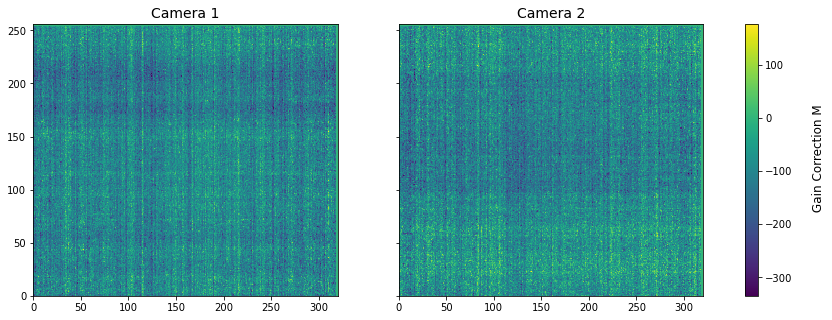

In [7]:
#plot DFCs
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5),sharey = True)
p1 = axes[0].pcolormesh(M1,shading = 'auto')
axes[0].set_title('Camera 1',fontsize = 14)

p2 = axes[1].pcolormesh(M2,shading = 'auto')
axes[1].set_title('Camera 2',fontsize = 14)
cbar = fig.colorbar(p1, ax=axes.ravel().tolist())
cbar.ax.set_ylabel('\n Gain Correction M',fontsize = 12)

plt.show()

In [8]:
#first, determine reference temp for each camera
df_ref = create_LUT_df(path,'35C.h5')

tref1 =  df_ref['temps1'].value_counts().idxmax() #most common FPA temp
tref2 =  df_ref['temps2'].value_counts().idxmax() #most common FPA temp

print('Ref T1 is '+ str(tref1))
print('Ref T2 is '+ str(tref2))

Ref T1 is 10.2
Ref T2 is 10.6


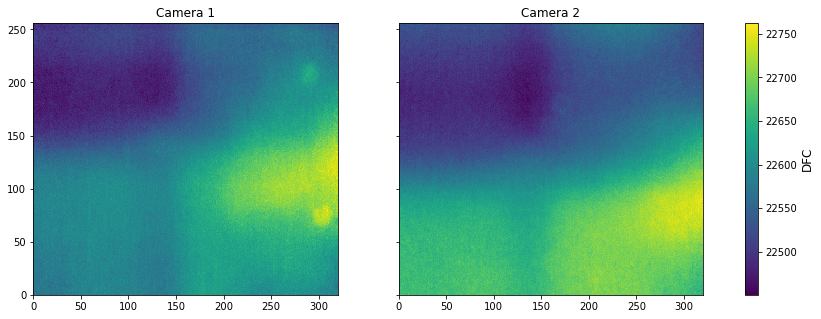

In [9]:
#load dark field correction
df_dark = create_LUT_df(path,'30Cdark.h5')

#correct DFC images for reference temp

'''determine DFC in camera 1 '''
D1s = [];
for i in range(len(df_dark)):
    corr = (tref1 - df_dark['temps1'][i])*M1
    offset = (df_dark['imgs1'][i]- corr)
    D1s.append(offset)
D1 = np.mean(D1s, axis =0)    
    
'''determine DFC in camera 1 '''
D2s = [];
for i in range(len(df_dark)):
    corr   = (tref2 - df_dark['temps2'][i])*M2
    offset = (df_dark['imgs2'][i]- corr)
    D2s.append(offset)
D2 = np.mean(D2s, axis =0)    

#plot DFCs
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5),sharey = True)
p1 = axes[0].pcolormesh(D1,shading = 'auto')
#axes[0].set_ylabel('Angular FOV [$^\circ$]',fontsize = 12)
#axes[0].set_xlabel('Wavelength [$\mu m$]'  ,fontsize = 12)
axes[0].set_title('Camera 1')

p2 = axes[1].pcolormesh(D2,shading = 'auto')
#axes[1].set_xlabel('Wavelength [$\mu m$]'  ,fontsize = 12)
axes[1].set_title('Camera 2')
cbar = fig.colorbar(p1, ax=axes.ravel().tolist())
cbar.ax.set_ylabel('DFC',fontsize = 12)

plt.show()

In [10]:
def DFC(im,t,tref,D,M):
    dark_corr = D + (tref-t)*M
    return(im-dark_corr)

def apply_DFC_to_df(df,D1,D2,tref1,tref2,M1,M2):
    imgs1 = []; temps1 = []
    imgs2 = []; temps2 = []
    for i in range(len(df)):
        im1  = df['imgs1'][i]
        t1   = df['temps1'][i]
        im1c =DFC(im1,t1,tref1,D1,M1)# take offset
        im1c = im1c + (tref1-t1)*M1 #rescale gain
        
        im2  = df['imgs2'][i]
        t2   = df['temps2'][i]
        im2c =DFC(im2,t2,tref2,D2,M2) 
        im2c = im2c + (tref2-t2)*M2 #rescale gain

        imgs1.append(im1c);temps1.append(t1)
        imgs2.append(im2c);temps2.append(t2)
        
    data_corrected = {'imgs1': imgs1,'imgs2': imgs2,'temps1': temps1, 'temps2' : temps2}
    df_corrected = pd.DataFrame.from_dict(data_corrected)
    return(df_corrected)

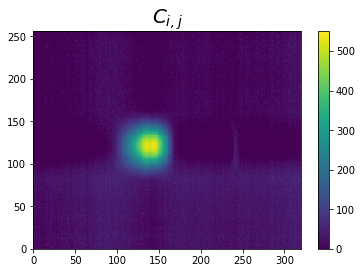

In [18]:
df_i = create_LUT_df(path,str(80)+'C.h5')
    
#apply 2 point NUC, this df cooresponds to Cij
df = apply_DFC_to_df(df_i,D1,D2,tref1,tref2,M1,M2)

rn = df['imgs2'][1];
plt.pcolormesh(rn+30,shading = 'auto')
plt.title('$C_{i,j}$',fontsize = 20)
plt.clim([0,550])
plt.colorbar()
plt.show()

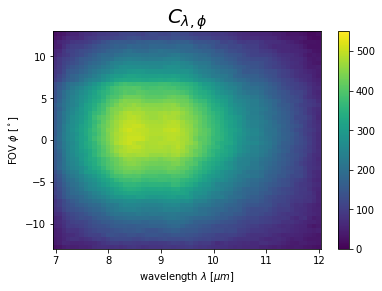

In [20]:
cn = pixel_registration(rn,cal_file2,waves,ymin2,ymax2)

X,Y = np.meshgrid(waves,angles)


plt.pcolormesh(X,Y,cn,shading = 'auto')
plt.title('$C_{\lambda,\phi}$',fontsize = 20)
plt.clim([0,550])
plt.ylabel('FOV $\phi$ [$^\circ$]')
plt.xlabel('wavelength $\lambda$ [$\mu m$]')
plt.colorbar()
plt.show()

In [21]:
#apply pixel registration and NUC to full dataset
mean_ims1 =[]
mean_ims2 =[]
std_ims1  =[]
std_ims2  =[]
t1s = []
t2s = []

for i in TEMPS:
    #will create a df and print the names of the keys in the original hdf5 file
    df_i = create_LUT_df(path,str(round(i))+'C.h5')
    
    #apply 2 point NUC, this df cooresponds to Cij
    df = apply_DFC_to_df(df_i,D1,D2,tref1,tref2,M1,M2)
    
    corrected_images1= [] ; 
    corrected_images2= [] ; 
    
    for i in range(len(df)):
        #load image
        rn = df['imgs1'][i];
        
        #apply pixel registration, this returns C lambda, phi
        T  = df['temps1'][i];
        t1s.append(T)
        cn = pixel_registration(rn,cal_file1,waves,ymin1,ymax1)
        corrected_images1.append(cn)
  

    for i in range(len(df)):
        #load image
        rn = df['imgs2'][i];
        
        #apply pixel registration
        T  = df['temps2'][i];
        t2s.append(T)
        cn = pixel_registration(rn,cal_file2,waves,ymin2,ymax2)
        corrected_images2.append(cn)
        

    mean_ims1.append(np.mean(corrected_images1,axis = 0))
    mean_ims2.append(np.mean(corrected_images2,axis = 0))

    std_ims1.append(np.std(corrected_images1,axis = 0))
    std_ims2.append(np.std(corrected_images2,axis = 0))
   

In [22]:
d = {'BB_temps': TEMPS, 'ims1': list(mean_ims1),'s1': list(std_ims1), 'ims2':list(mean_ims2),'s2': list(std_ims2)}

In [23]:
df = pd.DataFrame.from_dict(d, orient='index')
df = df.transpose()

In [25]:
df.to_hdf('/Volumes/KESU/calibration_data/LUT/05192021.h5', key='s')

In [26]:
#create sum column
df["totalrad"] = df['ims2']+df['ims1']
df["totalstd"] = (df['s2']**2+df['s1']**2)**0.5

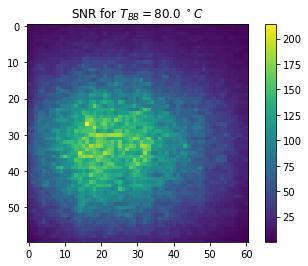

In [32]:
i =11;
plt.imshow(df["totalrad"][i]/df["totalstd"][i])
plt.colorbar()
#plt.clim(0,150)
plt.title('SNR for $T_{BB} = $' + str(TEMPS[i])+ ' $^\circ C$')
plt.show()

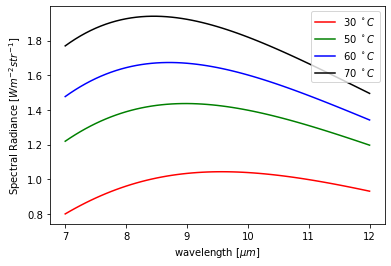

In [33]:
'''compare to BB function'''
def planck(wav, T):
    #adjust units
    T = T  + 273.15
    wav = wav*1e-6
    
    h = 6.626e-34
    c = 3.0e+8
    k = 1.38e-23
    a = 2.0*h*c**2
    b = h*c/(wav*k*T)
    intensity = 1/ ( (wav**5) * (exp(b) - 1.0) )/1e7
    return intensity

def planck_array(wav, T):
    #adjust units
    T = T  + 273.15
    wav = wav*1e-6
    
    h = 6.626e-34
    c = 3.0e+8
    k = 1.38e-23
    a = 2.0*h*c**2
    b = h*c/(wav*k*T)
    intensity = a/ ( (wav**5) * (np.exp(b) - 1.0) )/1e7
    return intensity

wavelengths = waves

#choose maximum resolvable temp to be 300 C
ref = planck_array(wavelengths, 300)

intensity40 = planck_array(wavelengths, 30.)
intensity50 = planck_array(wavelengths, 50.)
intensity60 = planck_array(wavelengths, 60.)
intensity70 = planck_array(wavelengths, 70.)

plt.plot(wavelengths, intensity40, 'r-', label = "30 $^\circ C$") 
plt.plot(wavelengths, intensity50, 'g-', label = "50 $^\circ C$") 
plt.plot(wavelengths, intensity60, 'b-', label = "60 $^\circ C$")
plt.plot(wavelengths, intensity70, 'k-', label = "70 $^\circ C$") 
 
# show the plot
plt.legend()
plt.xlabel('wavelength [$\mu m$]')
plt.ylabel('Spectral Radiance [$ W m^{-2} str^{-1}$]')
plt.show()

In [34]:
# pixel fit 
def f(I, A, B): 
    return A*I + B


In [35]:
def get_slice(df,x,y):
    sli = []
    for i in range(len(df)):
        s = df[i]
        sli.append(s[y,x])
    return(sli)

def get_slice_avg(df,x):
    sli = []
    for i in range(len(df)):
        s = df[i]
        sli.append(np.mean(s[:,x]))
    return(sli)

In [36]:
def calc_rad_coef(db):
    '''do pixel by pixel fit and determine A and B coefficients'''
    spec = len(db['ims1'][1][1])
    spat = len(db['ims1'][1])
    Ts = df['BB_temps'];
    
    #preallocate coefficient arrays
    A1 = np.zeros([spat,spec]);B1 = np.zeros([spat,spec]);
    A2 = np.zeros([spat,spec]);B2 = np.zeros([spat,spec]);
    At = np.zeros([spat,spec]);Bt = np.zeros([spat,spec]);
    
    for i in range(spat):
        for j in range(spec):
            #calculate spectral radiances at each temperature 
            Ts = np.array(df['BB_temps']);
            w = waves[j] #select wavelenth
            Is = []#preallocate array
            for T in Ts:
                spectral_radiance = planck(w, T)
                Is.append(spectral_radiance)
            Is= np.array(Is) 
            
            #import responses
            rs1 = get_slice(db['ims1'],j,i)
            rs2 = get_slice(db['ims2'],j,i)
            [a1,b1],cov1 = curve_fit(f, Is,  rs1)
            [a2,b2],cov2 = curve_fit(f, Is,  rs2)
            [at,bt],covt = curve_fit(f, Is,  np.add(rs1,rs2))
            A1[i,j] = a1;B1[i,j] =b1
            A2[i,j] = a2;B2[i,j] =b2
            At[i,j] = at;Bt[i,j] =bt
    return([A1,B1],[A2,B2],[At,Bt])        
 

In [37]:
[A1,B1],[A2,B2],[At,Bt] = calc_rad_coef(df)

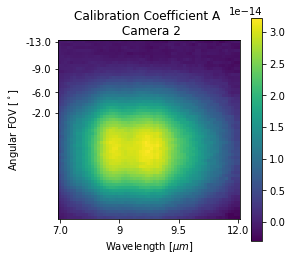

In [38]:
plt.matshow(A1,cmap = 'viridis' )
cbar = plt.colorbar()
plt.ylabel('Angular FOV [$^\circ$]') 
plt.xlabel('Wavelength [$\mu m$]')
plt.ax = plt.gca()
plt.ax.xaxis.set_ticks_position('bottom')
plt.xticks([0, 20, 40,60], [waves[0],round(waves[20]),waves[30],waves[60]])
plt.yticks([0, 9,17,24], [angles[0], angles[9],angles[17],angles[24]])
plt.title('Calibration Coefficient A \n Camera 2')
#plt.clim(-5,5)
plt.show()


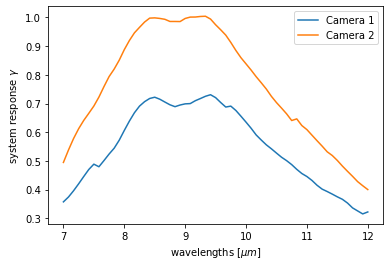

In [39]:
'''calculate transmission'''
gamma1 = []
gamma2 = []

for i in range(len(df)):
    T     = df['BB_temps'][i]
    Lbb   = planck_array(waves, T)
    C1    = np.mean(df['ims1'][i],axis = 0)
    C2    = np.mean(df['ims2'][i],axis = 0)

    g1=1-(Lbb/np.max(Lbb) - C1/np.max([C1,C2]))
    g2=1-(Lbb/np.max(Lbb) - C2/np.max([C1,C2]))
    
    gamma1.append(g1)
    gamma2.append(g2)



gamma1 = np.mean(gamma1,axis = 0)
gamma2 = np.mean(gamma2,axis = 0)


plt.plot(waves,gamma1,label = "Camera 1")
plt.plot(waves,gamma2,label = "Camera 2")
plt.legend()
plt.ylabel('system response $\gamma$')
plt.xlabel('wavelengths $[\mu m]$')
plt.show()

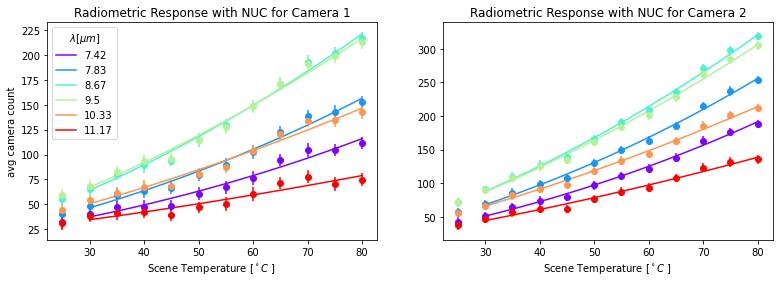

In [40]:
fig, axes = plt.subplots(ncols=2, figsize=(13, 4), tight_layout=False)

selected = [5, 10, 20,30,40,50]
colors = cm.rainbow(np.linspace(0, 1, len(selected)))
for i in range(len(selected)):
    
    x = selected[i]
    temps = np.linspace(30,80,51)

    Is = []#preallocate array
    for T in temps:
        spectral_radiance = planck(waves[x], T )
        Is.append(spectral_radiance)
    Is= np.array(Is) 

    fit1 = f(Is,np.mean(A1,0)[x],np.mean(B1,0)[x])
    fit2 = f(Is,np.mean(A2,0)[x],np.mean(B2,0)[x])
    
    axes[0].errorbar(df['BB_temps'],get_slice_avg(df['ims1'],x),yerr=get_slice_avg(df['totalstd'],x),c = colors[i],fmt='o')
    axes[0].plot(temps,fit1,c = colors[i],label =  str(round(waves[x],2)))
    axes[1].errorbar(df['BB_temps'],get_slice_avg(df['ims2'],x),yerr=get_slice_avg(df['totalstd'],x),c = colors[i],fmt='o')
    axes[1].plot(temps,fit2,c = colors[i])
axes[0].legend(title ='$\lambda [\mu m]$')
axes[0].set_title('Radiometric Response with NUC for Camera 1')
axes[1].set_title('Radiometric Response with NUC for Camera 2')
axes[0].set_xlabel('Scene Temperature [$^\circ C$ ] ')
axes[1].set_xlabel('Scene Temperature [$^\circ C$ ] ')
axes[0].set_ylabel('avg camera count')
plt.show()

In [41]:
#now, define inverse fit function, note this is broken
def finv(R,A,B):
    return (R-B)/A

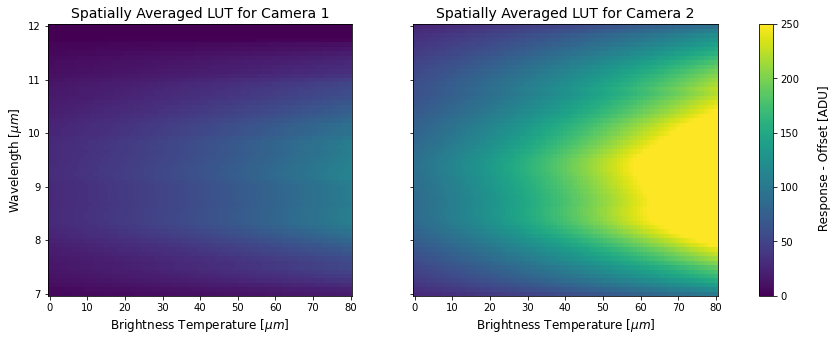

In [44]:
#let's build a lut
temps= np.linspace(0,80,91)

lut1 = np.zeros([len(waves),len(temps)])
lut2 = np.zeros([len(waves),len(temps)])

for t in range(len(temps)):
    ls1 = []
    ls2 = []
    for s in range(25):
        for w in range(len(waves)):
            I = planck(waves[w], temps[t])
            l1 = f(I,A1[s],B1[s]) - B1[s]
            ls1.append(l1)
            l2 = f(I,A2[s],B2[s]) - B2[s]
            ls2.append(l2)
        lut1[:,t] = np.mean(ls1,0)
        lut2[:,t] = np.mean(ls2,0)

X,Y = np.meshgrid(temps,waves)


fig, axes = plt.subplots(ncols=2, figsize=(15, 5), tight_layout=False,sharey =True)

pl1 = axes[0].pcolormesh(X,Y,lut1,shading ='auto')
pl1.set_clim(0,250)
axes[0].set_title('Spatially Averaged LUT for Camera 1',fontsize = 14)
axes[0].set_ylabel('Wavelength [$\mu m$]',fontsize = 12)
axes[0].set_xlabel('Brightness Temperature [$\mu m$]',fontsize = 12)

pl2 =axes[1].pcolormesh(X,Y,lut2,shading ='auto')
pl2.set_clim(0,250)
axes[1].set_title('Spatially Averaged LUT for Camera 2',fontsize = 14)
axes[1].set_xlabel('Brightness Temperature [$\mu m$]',fontsize = 12)


cbar = fig.colorbar(pl1, ax=axes.ravel().tolist())
cbar.ax.set_ylabel('\n Response - Offset [ADU]',fontsize = 12)


plt.show()


In [45]:
lc1=np.zeros([91,61])
lc2=np.zeros([91,61])

for i in range(len(lut1[1])):
    lc1[i] = lut1[:,i]/gamma1
    lc2[i] = lut2[:,i]/gamma2

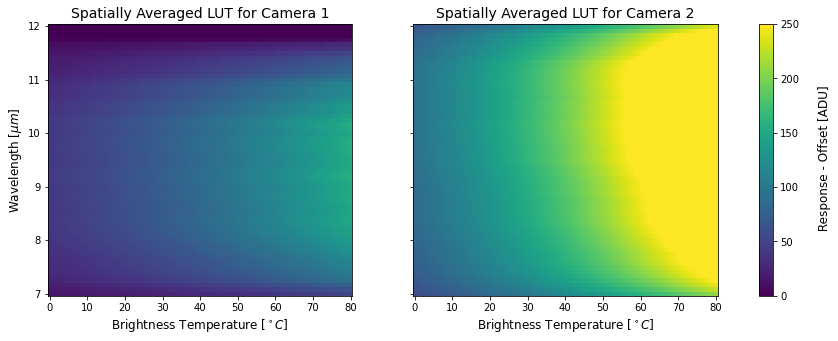

In [46]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 5), tight_layout=False,sharey =True)
pl1 = axes[0].pcolormesh(X,Y,np.transpose(lc1),shading ='auto')
pl1.set_clim(0,250)
axes[0].set_title('Spatially Averaged LUT for Camera 1',fontsize = 14)
axes[0].set_ylabel('Wavelength [$\mu m$]',fontsize = 12)
axes[0].set_xlabel('Brightness Temperature [$^\circ C$]',fontsize = 12)

pl2 =axes[1].pcolormesh(X,Y,np.transpose(lc2),shading ='auto')
pl2.set_clim(0,250)
axes[1].set_title('Spatially Averaged LUT for Camera 2',fontsize = 14)
axes[1].set_xlabel('Brightness Temperature [$^\circ C$]',fontsize = 12)


cbar = fig.colorbar(pl1, ax=axes.ravel().tolist())
cbar.ax.set_ylabel('\n Response - Offset [ADU]',fontsize = 12)


plt.show()


In [154]:
#writetohdf5

#choose filepath to desired data
save_path =   '/Volumes/KESU/calibration_files/'
name =  "LUT2" 

#create hdf5 file
hf = h5py.File(save_path + name + '.h5', 'w')
hf.create_dataset('/A1',  data= A1)
hf.create_dataset('/B1',  data= B1)
hf.create_dataset('/A2',  data= A2)
hf.create_dataset('/B2',  data= B2)
hf.create_dataset('/At',  data= At)
hf.create_dataset('/Bt',  data= Bt)

hf.create_dataset('/gamma1',  data= gamma1)
hf.create_dataset('/gamma2',  data= gamma2)
hf.close()